In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import copy 
import os

import torch
import torchvision

import pandas as pd
import sklearn

from torchvision import transforms, utils
import PIL
from torch.autograd import Variable


import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=beb486dd683a0e1ed342fc9e282fed4e4b815dd8cb38260e31b30bf044c948d2
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p data
!cp '/content/drive/Shareddrives/UCI CS175 Team23/training_solutions_rev1.csv' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_training_rev1.zip' -d ./data/

In [5]:
!ls data

images_training_rev1  training_solutions_rev1.csv


In [6]:
training_data_path = '/content/data/images_training_rev1'
solution_path = '/content/data/training_solutions_rev1.csv'

In [7]:
df = pd.read_csv(solution_path)

In [8]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


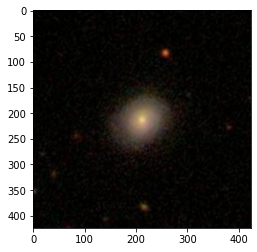

In [9]:
plt.imshow(plt.imread(training_data_path + "/" + str(df["GalaxyID"][0]) + ".jpg"))

In [10]:
# reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class GalaxyDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, usr_root_dir, usr_transforms=None):
    self.solution = pd.read_csv(solution_path)
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms

  def __len__(self):
    return len(self.solution)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = self.root_dir + "/" + str(self.solution.iloc[idx,0]) + ".jpg"
    id = self.solution.iloc[idx,0]
    #image = plt.imread(img_name).T
    image = PIL.Image.open((img_name))
    image = self.transforms(image)
    proba = self.solution.iloc[idx,1:].to_numpy()
    #image = np.moveaxis(image.numpy()*255, 0, -1).astype("uint8")
    return  image, proba, id

In [106]:
galaxy_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(int(224/2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(50),
    transforms.ToTensor()
    ])

tri_full = GalaxyDataset(solution_path, training_data_path, galaxy_transform)

In [12]:
def show_image(sample_image):
  example_img = np.moveaxis(sample_image.numpy()*255, 0, -1).astype("uint8")
  plt.imshow(example_img)


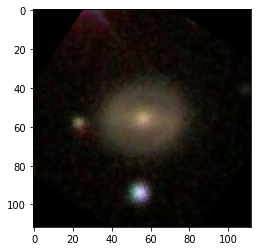

In [126]:
show_image(tri_full[np.random.choice(40000)][0])

In [127]:
a, b = torch.utils.data.random_split(tri_full, [43104, 18474], torch.Generator().manual_seed(1234))

loader_train = torch.utils.data.DataLoader(a, batch_size=64)
loader_valid = torch.utils.data.DataLoader(b)

loader_train_full = torch.utils.data.DataLoader(tri_full, batch_size=100)

gpu_dtype = torch.cuda.FloatTensor

In [15]:
def custom_train(model, loader, loss_fn, optimizer, num_epochs = 1):
    epoch_log = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()

        t_log = []
        for t, (x, y, _) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype))
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            
            if (t + 1) % 500 == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))
            t_log.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Total iteration:", len(t_log))
        epoch_log.append(max(t_log))   
    
    fig = plt.figure(figsize=(7,7))
    plt.plot(epoch_log)
    plt.ylim(0, 3)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    return epoch_log

In [16]:
def check_accuracy(model, loader, num_sample):
    model.eval() 
    #temp = torch.ones([1,37]).type(gpu_dtype)
    temp = 0
    count = 0
    with torch.no_grad():
      for x, y, id in loader:
          # 
          x_var = Variable(x.type(gpu_dtype))
          y_var = Variable(y.type(gpu_dtype))
          
          scores = model(x_var)
          scores[scores < 0] = 0
          diff = y_var - scores
          

          # print(scores)
          # print(y_var)
          # print(diff , "\n")
          #temp += torch.square(diff)
          temp += torch.sqrt(torch.mean(torch.square(diff)))
          #temp += diff
          count += 1
          if num_sample == count:
            break
    print(temp / num_sample)
    #print(torch.sqrt(torch.mean(torch.div(temp, len(loader)))))
    print( temp / len(loader) )
    #print(torch.sqrt(torch.mean(torch.square(torch.div(temp, len(loader))))))
  

In [17]:
!cp '/content/drive/Shareddrives/UCI CS175 Team23/images_test_rev1.zip' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_test_rev1.zip' -d ./data/
!ls data

images_test_rev1      images_training_rev1
images_test_rev1.zip  training_solutions_rev1.csv


In [18]:
class GalaxyTestDataset(torch.utils.data.Dataset):
  def __init__(self, usr_root_dir, usr_transforms=None):
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms
    self.images_path = os.listdir(usr_root_dir)

  def __len__(self):
    return len(self.images_path)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    self.images_path.sort()
    file_paths = self.images_path
    img_name = self.root_dir + "/" + file_paths[idx]
    id = int(file_paths[idx].split(".")[0])

    image = PIL.Image.open((img_name))
    image = self.transforms(image)

    return  image, id

In [171]:
test_data_path = '/content/data/images_test_rev1'
test_full = GalaxyTestDataset(test_data_path, transforms.ToTensor())

In [176]:
def write_prediction(model, loader, output_name, header_list):
  model.eval() 
  num_sample = len(loader)

  numpy_temp = np.ones((num_sample, 38))

  count = 0
  with torch.no_grad():
    for x, id in loader:
        x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        scores[scores < 0] = 0
        scores[scores > 1] = 1
        
        scores_numpy = scores.cpu().detach().numpy()

        
        numpy_temp[count][0] = id
        numpy_temp[count][1:] = scores_numpy

        count += 1

        

  something = pd.DataFrame(numpy_temp)

  something.columns = header_list
  something = something.astype({"GalaxyID": "int64"})

  print(something.head())

  something.to_csv(output_name,  index=False)

  return numpy_temp

In [140]:
effnet = EfficientNet.from_pretrained("efficientnet-b2")
print(effnet._fc)
#effnet._fc = nn.Linear(1280, 37)
#effnet._fc = nn.Linear(1536, 10)
effnet._fc = nn.Linear(1408, 37)
effnet.cuda()
opt = optim.SGD(effnet.parameters(), lr=0.1)

Loaded pretrained weights for efficientnet-b2
Linear(in_features=1408, out_features=1000, bias=True)


In [149]:
effnet.load_state_dict(torch.load("effnet-full-state.pt")["model"])
opt.load_state_dict(torch.load("effnet-full-state.pt")["optim"])

In [ ]:
effnet.state_dict()

Starting epoch 1 / 10
t = 500, loss = 0.0136
Total iteration: 616
Starting epoch 2 / 10
t = 500, loss = 0.0137
Total iteration: 616
Starting epoch 3 / 10
t = 500, loss = 0.0136
Total iteration: 616
Starting epoch 4 / 10
t = 500, loss = 0.0130
Total iteration: 616
Starting epoch 5 / 10
t = 500, loss = 0.0127
Total iteration: 616
Starting epoch 6 / 10
t = 500, loss = 0.0126
Total iteration: 616
Starting epoch 7 / 10
t = 500, loss = 0.0133
Total iteration: 616
Starting epoch 8 / 10
t = 500, loss = 0.0126
Total iteration: 616
Starting epoch 9 / 10
t = 500, loss = 0.0121
Total iteration: 616
Starting epoch 10 / 10
t = 500, loss = 0.0120
Total iteration: 616
CPU times: user 43min 32s, sys: 2min 57s, total: 46min 30s
Wall time: 46min 26s


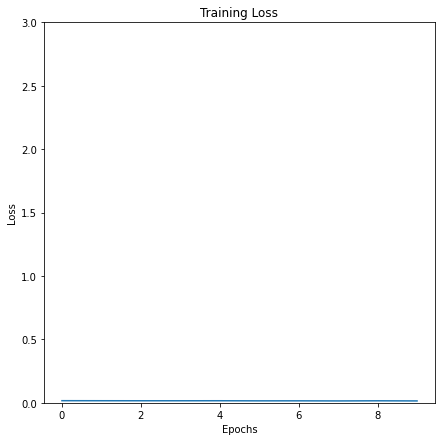

In [151]:
loss = nn.MSELoss().type(gpu_dtype)
%time effnet_training_loss = custom_train(effnet, loader_train_full, loss, opt, 10)

# CPU times: user 1h 20min 17s, result: 0.11
# CPU times: user 21min 43s, result: 0.112
# CPU times: user 21min 43s, result: 0.103
# CPU times: user 43min 32s, result: 0.096

In [162]:
check_accuracy(effnet, loader_valid, 1000)

tensor(0.0948, device='cuda:0')
tensor(0.0051, device='cuda:0')


In [172]:
loader_test = torch.utils.data.DataLoader(test_full)

In [177]:
%time write_prediction(effnet, loader_test, "effnet-b2-full-best.csv", df.columns.values)

   GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0    100018  0.531893  0.363992  ...    0.00039   0.003843   0.028259
1    100037  0.475053  0.416950  ...    0.00000   0.012312   0.034921
2    100042  0.575008  0.324604  ...    0.00000   0.000482   0.005065
3    100052  0.504287  0.386176  ...    0.00000   0.015998   0.025461
4    100056  0.456807  0.440469  ...    0.00000   0.000000   0.029110

[5 rows x 38 columns]
CPU times: user 27min 53s, sys: 13.3 s, total: 28min 6s
Wall time: 28min 3s


array([[1.00018000e+05, 5.31893075e-01, 3.63991976e-01, ...,
        3.89633700e-04, 3.84312775e-03, 2.82591525e-02],
       [1.00037000e+05, 4.75053072e-01, 4.16949809e-01, ...,
        0.00000000e+00, 1.23118833e-02, 3.49210240e-02],
       [1.00042000e+05, 5.75008452e-01, 3.24603558e-01, ...,
        0.00000000e+00, 4.81911469e-04, 5.06481528e-03],
       ...,
       [9.99990000e+05, 4.47033346e-01, 4.53272641e-01, ...,
        0.00000000e+00, 1.80203142e-03, 1.93192475e-02],
       [9.99994000e+05, 4.22322512e-01, 4.75064099e-01, ...,
        1.44346710e-03, 8.65598209e-03, 5.28387874e-02],
       [9.99996000e+05, 5.08842707e-01, 3.73322517e-01, ...,
        4.25596116e-03, 2.01229658e-03, 2.35466138e-02]])

In [178]:
torch.save(effnet, "effnet-b2-full-best.pt")
torch.save({"model": effnet.state_dict(),
            "optim": opt.state_dict()},
           "effnet-full-state-best.pt")

In [ ]:
effnet.state_dict()

In [179]:
!cp effnet-b2-full-best.csv '/content/drive/Shareddrives/UCI CS175 Team23'
!cp effnet-b2-full-best.pt '/content/drive/Shareddrives/UCI CS175 Team23'
!cp effnet-full-state-best.pt '/content/drive/Shareddrives/UCI CS175 Team23'

In [ ]:
%time check_accuracy(effnet, loader_valid, 1)

In [ ]:
torch.save(effnet, "effnet.pt")

In [ ]:
effnet.state_dict()

In [ ]:
loaded_model = torch.load('/content/drive/Shareddrives/UCI CS175 Team23/effnet.pt' )

In [ ]:
loaded_model.state_dict()

In [ ]:
check_accuracy(loaded_model, loader_valid, 10)

In [ ]:
%time test_solution = write_prediction(loaded_model, loader_test, "numpy_temp.csv",  df.columns.values)

   GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0    999996  0.662544  0.312697  ...    0.00267    0.00155   0.031011
1         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000
2         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000
3         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000
4         1  1.000000  1.000000  ...    1.00000    1.00000   1.000000

[5 rows x 38 columns]
CPU times: user 30min 36s, sys: 11.8 s, total: 30min 47s
Wall time: 30min 41s


In [ ]:
!cp numpy_temp.csv "/content/drive/Shareddrives/UCI CS175 Team23/"

In [ ]:
!cp effnet.pt "/content/drive/Shareddrives/UCI CS175 Team23/"

In [ ]:
fixed_model_base = nn.Sequential( # You fill this in!
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(2, 2),

                    nn.Flatten(),
                    nn.Linear(5408, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 37)
                )

fixed_model_gpu = fixed_model_base.type(torch.cuda.FloatTensor)